# Imports:

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr, ttest_ind
from os.path import join, sep
import Config as c
valid_users = c.valid_users
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Set working environment:

In [2]:
cloud = False
if cloud:
    data_path = c.cloud_data_path
else:
    data_path = c.data_path

# Read Data:

In [3]:
clinic_df = pd.read_pickle(join(data_path, 'clinic_processed_pickle.p'))
clinic_df.name = 'clinic_df'

clinic_steps_df = pd.read_pickle(join(data_path, 'clinic_steps_processed_pickle.p'))
clinic_steps_df.name = 'clinic_df_with_steps'

home_df = pd.read_pickle(join(data_path, 'home_processed_pickle.p'))
home_df.name = 'home_df'

home_steps_df = pd.read_pickle(join(data_path, 'home_steps_processed_pickle.p'))
home_steps_df.name = 'home_df_with_steps'

reminders_df = pd.read_pickle(join(c.data_path, 'reminder_five_minutes_processed_pickle.p'))
reminders_df.name = 'reminders_df'

In [4]:
print(sorted(clinic_df.user_id.unique().astype(int).tolist()))
print(sorted(home_df.user_id.unique().astype(int).tolist()))
print(sorted(reminders_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_df.user_id.unique().astype(int).tolist()))

[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]


# Set some important variables + define summary function:

In [5]:
clinic_patients_reports = clinic_df.patient_report_value
clinic_clinicians_reports = clinic_df.clinician_report_value
home_patients_reports = home_df.patient_report_value
reminders_patients_reports = reminders_df.patient_report_value

In [6]:
statistics = ['median', 'mean', np.std]
min_val = c.report_values[0]
max_val = c.report_values[-1]

In [54]:
def plot_statistics_distribution(df, assessment_id, user_id, target_variable,
                                 statistics, with_median = False,
                                 min_val=min_val, max_val=max_val, bars_gap=0.5):
    
    # Show the number of assessments per user in the given dataset:
    print('\nNumber of assessments per user in this dataset:')
    print(df[[user_id, assessment_id]].groupby(user_id)[assessment_id].nunique(), '\n')
    
    # Aggregate (mean) the reported target variable per assessment: 
    grouped_reports = df[[assessment_id, user_id, target_variable]].groupby(assessment_id, as_index=False).agg('mean')
    reports = grouped_reports[target_variable].astype(int)
    
    # Count report appearances for each possible value (even if didn't appear):
    counts = []
    for x in c.report_values:
        x_count = len([r for r in reports if r==x])
        counts.append(x_count)
    
    # Plot the reported values distribution across all assessments:
    fig, ax = plt.subplots()
    ax.bar(c.report_values, counts, width=0.4, align='center')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('%s distribution across all records in %s' % (target_variable, df.name))
    ax.set_xlabel('Reported Chorea')
    ax.set_ylabel('Count')
    plt.show()

    
    # Aggregate (mean, std, median) all assessments per patient:
    print('\n')
    per_user_stats = grouped_reports[[user_id, target_variable]].groupby(user_id, as_index=False).agg(statistics)
    per_user_stats.columns = per_user_stats.columns.droplevel(0)
    per_user_stats.reset_index(inplace=True)
    
    means = per_user_stats['mean']
    stds = per_user_stats['std']
    if with_median:
        medians = per_user_stats['median']
    users = per_user_stats['user_id'].astype(str)
    n_users = users.shape[0]
    users_enum = range(1, n_users+1)
    
    # Bar plot - mean + error bars (optional: median)
    width = 0.3
    fig = plt.figure(2)
    ax = fig.add_subplot(111)

    rects1 = ax.bar(users_enum, means, width, color='g', yerr=stds)
    if with_median:
        rects2 = ax.bar(users_enum+width, medians, width, color='b')
    
    ax.set_title('Summary statistics per patient in %s' %(df.name))
    ax.set_xlabel('Patient ID')
    if with_median:
        ax.set_ylabel('Reported Chorea')
        ax.set_xticks(users_enum+(0.5*width))
        ax.legend((rects1[0], rects2[0]), ('Mean', 'Median'))
    else:
        ax.set_ylabel('Mean Reported Chorea')
        ax.set_xticks(users_enum)    
    ax.set_xticklabels(users)
    plt.show()
    
    # Plot per-patient mean reported value (as dots) + error bars:
    plt.xticks(users_enum, users)
    plt.errorbar(users_enum, means, stds, color='b', fmt='.', markersize='10',
                 ecolor='r',capsize=4, elinewidth=2, linestyle='None')
    plt.ylim(min_val-bars_gap, max_val+bars_gap)
    plt.title('Mean Report Chorea +/- Standatd Variation, Per Patient')
    plt.xlabel('Patient ID')
    plt.ylabel('Mean Reported Chorea')
    plt.show()
    
    # Calculate the fraction of 'positive' reports per patient, and plot:
    print('\n')
    grouped_reports['binary_report'] = grouped_reports[target_variable]>=1
    binary_avg = grouped_reports[[user_id, 'binary_report']].groupby(user_id, as_index=False).agg('mean')
    binary_avg['user_id'] = binary_avg['user_id'].astype(str)

    plt.figure(4)
    plt.bar(users_enum, binary_avg['binary_report'])
    plt.xticks(users_enum, binary_avg['user_id'])
    plt.title('Fraction of positive (>1) reports per patient in %s' %(df.name))
    plt.xlabel('Patient ID')
    plt.ylabel('Fraction of positive reports')
    plt.show()
    
    return

(-0.5, 4.5)

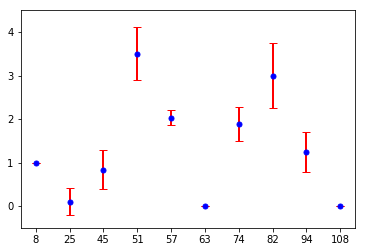

In [44]:
df = home_df
assessment_id='assessment_id'
user_id = 'user_id'
target_variable = 'patient_report_value'


grouped_reports = df[[assessment_id, user_id, target_variable]].groupby(assessment_id, as_index=False).agg('mean')

per_user_stats = grouped_reports[[user_id, target_variable]].groupby(user_id, as_index=False).agg(statistics)
per_user_stats.columns = per_user_stats.columns.droplevel(0)
per_user_stats.reset_index(inplace=True)

users = per_user_stats['user_id'].astype(str)
n_users = users.shape[0]
# x_locs = np.arange(1, n_users+1)
users_enum = range(1, n_users+1)
means = per_user_stats['mean']
stds = per_user_stats['std']
plt.xticks(users_enum, users)

plt.errorbar(users_enum, means, stds, color='b', fmt='.', markersize='10',
             ecolor='r',capsize=4, elinewidth=2, linestyle='None')
plt.ylim(-0.5, 4.5)


In [20]:
per_user_stats.head(15)

,user_id,median,mean,std
0,8,1.0,1.000000,0.000000
1,25,0.0,0.100000,0.305129
2,45,1.0,0.839286,0.458328
3,51,4.0,3.507692,0.615505
4,57,2.0,2.030303,0.172292
5,63,0.0,0.000000,0.000000
6,74,2.0,1.895522,0.392958
7,82,3.0,3.000000,0.738549
8,94,1.0,1.250000,0.462910
9,108,0.0,0.000000,0.000000


## Present reports from the lab, per assessment:

In [8]:
clinic_df[['user_id', 'assessment_id', 'patient_report_value', 'clinician_report_value']].\
groupby(['user_id', 'assessment_id'], as_index=False).agg('mean').head(15)

,user_id,assessment_id,patient_report_value,clinician_report_value
0,8,1490640580656,1.0,2.0
1,25,1487605701264,1.0,2.0
2,25,1493912424448,0.0,2.0
3,45,1490637319938,2.0,3.0
4,51,1490284781631,3.0,2.0
5,57,1481923232988,1.0,2.0
6,63,1493920652116,0.0,2.0
7,74,1485546321147,2.0,2.0
8,82,1489765988342,3.0,4.0
9,94,1493741957038,3.0,2.0


## Inspect patients' reports for lab assessments:


Number of assessments per user in this dataset:
user_id
8      1
25     2
45     1
51     1
57     1
63     1
74     1
82     1
94     1
108    1
Name: assessment_id, dtype: int64 



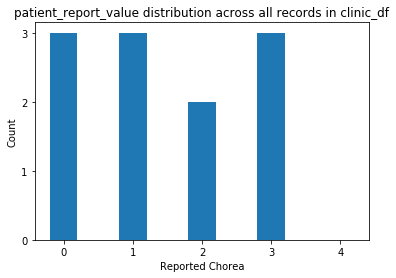

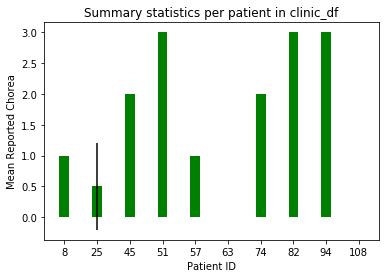

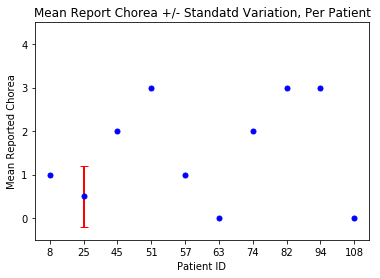

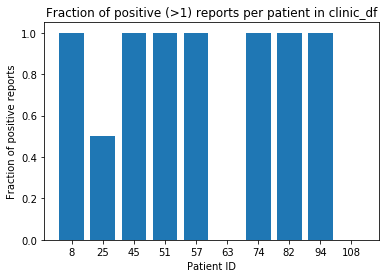

In [48]:
plot_statistics_distribution(clinic_df, assessment_id='assessment_id',
                             user_id ='user_id',
                             target_variable='patient_report_value', statistics=statistics)

## Inspect clinicians' reports for lab assessments:


Number of assessments per user in this dataset:
user_id
8      1
25     2
45     1
51     1
57     1
63     1
74     1
82     1
94     1
108    1
Name: assessment_id, dtype: int64 



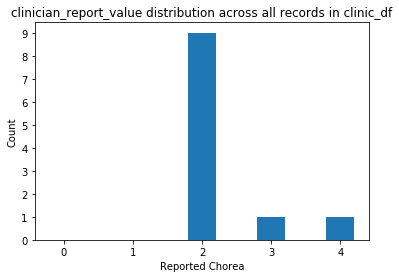

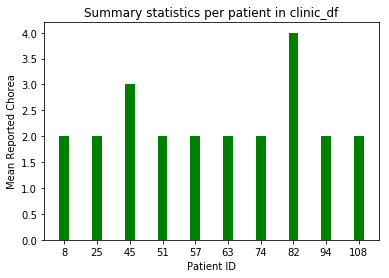

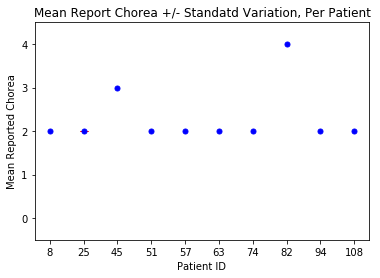

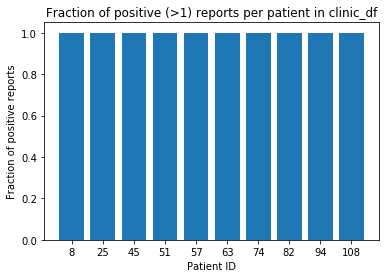

In [49]:
plot_statistics_distribution(clinic_df, assessment_id='assessment_id',
                             user_id ='user_id',
                             target_variable='clinician_report_value', statistics=statistics)

## Inspect patients' reports for home assessments:


Number of assessments per user in this dataset:
user_id
8       25
25      30
45      56
51      65
57      99
63      12
74     134
82      34
94       8
108     37
Name: assessment_id, dtype: int64 



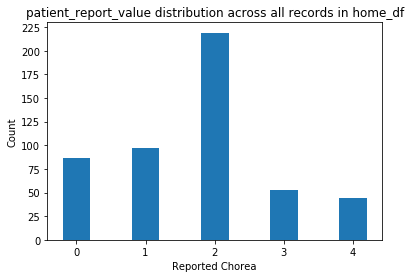

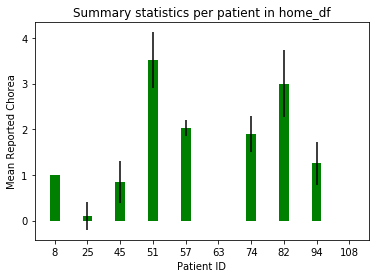

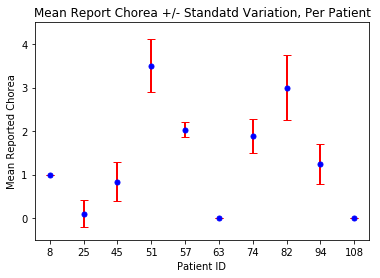

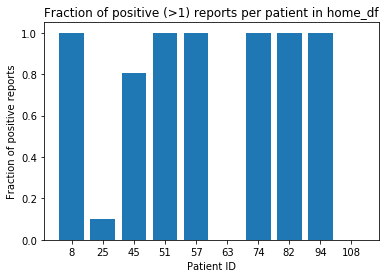

In [50]:
plot_statistics_distribution(home_df, assessment_id='assessment_id',
                             user_id ='user_id',
                             target_variable='patient_report_value', statistics=statistics)

## Inspect patients' reports for pre-reminder 5-minutes segments:


Number of assessments per user in this dataset:
user_id
8       48
45       6
51      35
57     305
63      28
74     204
82      73
94      18
108     78
Name: reminder_id, dtype: int64 



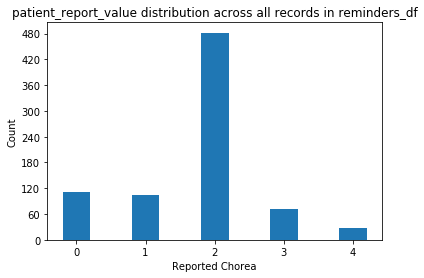

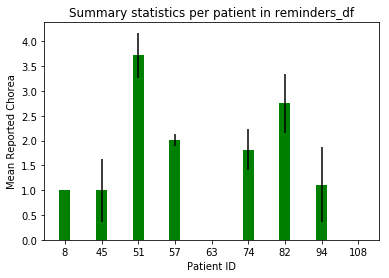

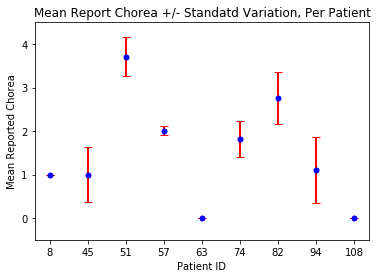

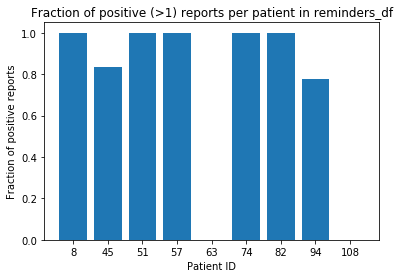

In [55]:
plot_statistics_distribution(reminders_df, assessment_id='reminder_id',
                             user_id ='user_id',
                             target_variable='patient_report_value', statistics=statistics)

## Lab data: patients' reports vs. clinicians' reports:

    assessment_id  patient_report_value  clinician_report_value
0   1481923232988                   1.0                     2.0
1   1485546321147                   2.0                     2.0
2   1487605701264                   1.0                     2.0
3   1488396181636                   0.0                     2.0
4   1489765988342                   3.0                     4.0
5   1490284781631                   3.0                     2.0
6   1490637319938                   2.0                     3.0
7   1490640580656                   1.0                     2.0
8   1493741957038                   3.0                     2.0
9   1493912424448                   0.0                     2.0
10  1493920652116                   0.0                     2.0

Correlation of: 0.463 
p-value of: 0.151


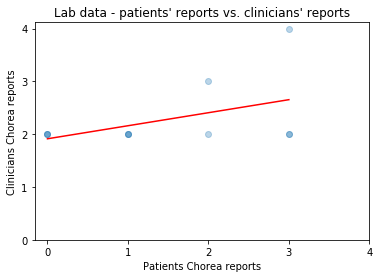

In [13]:
report_per_assess = clinic_df[['assessment_id', 'patient_report_value', 'clinician_report_value']]\
                    .groupby('assessment_id', as_index=False).agg('mean')
print(report_per_assess.head(15))
patients = report_per_assess.patient_report_value
clinicians = report_per_assess.clinician_report_value

coef, p_val = pearsonr(patients, clinicians)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(patients, clinicians, alpha=0.3)
plt.plot(np.unique(patients),
         np.poly1d(np.polyfit(patients, clinicians, 1))(np.unique(patients)),
         color='r')
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel('Patients Chorea reports')
plt.ylabel('Clinicians Chorea reports')
plt.title("Lab data - patients' reports vs. clinicians' reports")
plt.show()

## Patients' lab assessments reports vs. their (mean) home assessments reports:


Correlation of: 0.769 
p-value of: 0.009


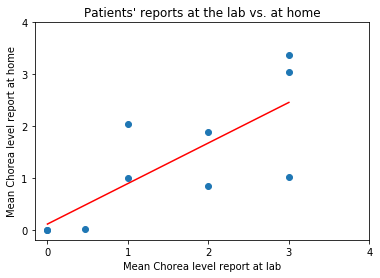

In [14]:
clinic_report_per_user = clinic_df[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
clinic_report_per_user.columns = ['clinic_mean_report']
clinic_report_per_user.sort_index(inplace=True)

home_report_per_user = home_df[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_report_per_user.columns = ['home_mean_report']
home_report_per_user.sort_index(inplace=True)

both_reports = pd.concat([clinic_report_per_user, home_report_per_user], axis=1)
both_reports.dropna(inplace=True)
both_reports.reset_index(inplace=True)

clinic_mean = both_reports.clinic_mean_report
home_mean = both_reports.home_mean_report

coef, p_val = pearsonr(clinic_mean, home_mean)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(clinic_mean, home_mean)
plt.plot(np.unique(clinic_mean),
         np.poly1d(np.polyfit(clinic_mean, home_mean, 1))(np.unique(clinic_mean)),
         color='r')
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel('Mean Chorea level report at lab')
plt.ylabel('Mean Chorea level report at home')
plt.title("Patients' reports at the lab vs. at home")
plt.show()

## Clinicians' lab assessments reports vs. their (mean) home assessments reports:


Correlation of: 0.398 
p-value of: 0.255


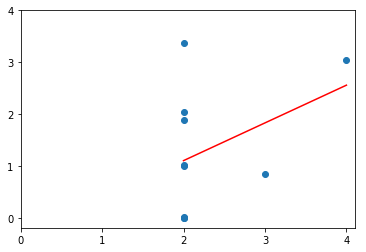

In [15]:
clinic_report_per_user = clinic_df[['user_id', 'clinician_report_value']].groupby('user_id').agg('mean')
clinic_report_per_user.columns = ['clinic_mean_report']
clinic_report_per_user.sort_index(inplace=True)

home_report_per_user = home_df[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_report_per_user.columns = ['home_mean_report']
home_report_per_user.sort_index(inplace=True)

both_reports = pd.concat([clinic_report_per_user, home_report_per_user], axis=1)
both_reports.dropna(inplace=True)
both_reports.reset_index(inplace=True)

clinic_mean = both_reports.clinic_mean_report
home_mean = both_reports.home_mean_report

coef, p_val = pearsonr(clinic_mean, home_mean)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(clinic_mean, home_mean)
plt.plot(np.unique(clinic_mean),
         np.poly1d(np.polyfit(clinic_mean, home_mean, 1))(np.unique(clinic_mean)),
         color='r')
plt.xticks(range(5))
plt.yticks(range(5))
# plt.xlabel('Mean Chorea level report at lab')
# plt.ylabel('Mean Chorea level report at home')
# plt.title("Patients' reports at the lab vs. at home")
plt.show()

## Patients' mean home pre-reminders reports vs. their mean home assessments reports:


Correlation of: 0.994 
p-value of: 0.000


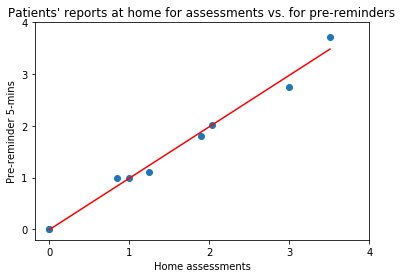

In [23]:
home_unique_assessments = home_df[['user_id', 'assessment_id', 'patient_report_value']]\
.groupby(['user_id', 'assessment_id'], as_index=False).agg('mean')
home_assess_patient_avg = home_unique_assessments[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_assess_patient_avg.columns = ['assessments_mean_report_value']
home_assess_patient_avg.sort_index(inplace=True)

home_unique_reminders = reminders_df[['user_id', 'reminder_id', 'patient_report_value']]\
.groupby(['user_id', 'reminder_id'], as_index=False).agg('mean')
home_remind_patient_avg = home_unique_reminders[['user_id', 'patient_report_value']].groupby('user_id').agg('mean')
home_remind_patient_avg.columns = ['reminders_mean_report_value']
home_remind_patient_avg.sort_index(inplace=True)

both_home = pd.concat([home_assess_patient_avg, home_remind_patient_avg], axis=1)
both_home.dropna(inplace=True)

assess_mean = both_home.assessments_mean_report_value
remind_mean = both_home.reminders_mean_report_value

coef, p_val = pearsonr(assess_mean, remind_mean)
print('\n' 'Correlation of: %.3f \np-value of: %.3f' % (coef, p_val))

plt.scatter(assess_mean, remind_mean)
plt.plot(np.unique(assess_mean),
         np.poly1d(np.polyfit(assess_mean, remind_mean, 1))(np.unique(assess_mean)),
         color='r')
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel('Home assessments')
plt.ylabel('Pre-reminder 5-mins')
plt.title("Patients' reports at home for assessments vs. for pre-reminders")
plt.show()

# Raw accelerometer data analysis:

In [36]:
clinic_df['acc_norm'] = np.sqrt((clinic_df.x)**2 + (clinic_df.y)**2 + (clinic_df.z)**2)
clinic_df['acc_abs_delta'] = abs(clinic_df['acc_norm']-1000)

clinic_steps_df['acc_norm'] = np.sqrt((clinic_steps_df.x)**2 + (clinic_steps_df.y)**2 + (clinic_steps_df.z)**2)
clinic_steps_df['acc_abs_delta'] = abs(clinic_steps_df['acc_norm']-1000)

home_df['acc_norm'] = np.sqrt((home_df.x)**2 + (home_df.y)**2 + (home_df.z)**2)
home_df['acc_abs_delta'] = abs(home_df['acc_norm']-1000)

home_steps_df['acc_norm'] = np.sqrt((home_steps_df.x)**2 + (home_steps_df.y)**2 + (home_steps_df.z)**2)
home_steps_df['acc_abs_delta'] = abs(home_steps_df['acc_norm']-1000)

reminders_df['acc_norm'] = np.sqrt((reminders_df.x)**2 + (reminders_df.y)**2 + (reminders_df.z)**2)
reminders_df['acc_abs_delta'] = abs(reminders_df['acc_norm']-1000)

In [44]:
def mean_acc_box_plot(df, report_column, variable_column, group_by='assessment_id'):
    mean_acc_df = df[[group_by, variable_column, report_column]]\
                    .groupby(group_by, as_index=False).agg('mean')
    discrete_report_values = c.report_values
    boxes_vals = [np.asarray(mean_acc_df[variable_column][mean_acc_df[report_column] == x]) for x in discrete_report_values]
    plt.boxplot(boxes_vals)
    plt.xticks(range(min_val+1, max_val+2), range(5))
#     plt.ylim((920, 1100))
    plt.xlabel('Reported Chorea')
    plt.ylabel('Accelerometer norm mean')
    plt.show()

### Accelerometer norm mean vs. reported Chorea - clinic patients' reports:

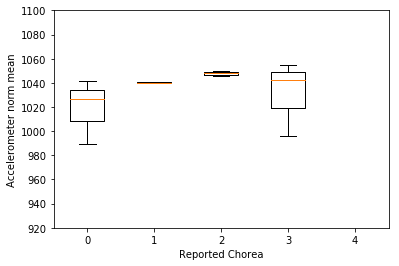

In [26]:
mean_acc_box_plot(clinic_df, 'patient_report_value', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - clinic clinicians' reports:

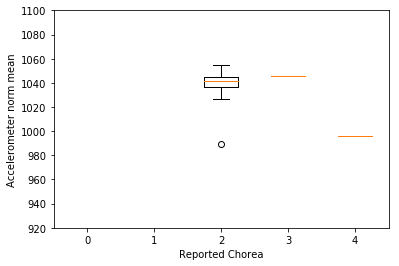

In [27]:
mean_acc_box_plot(clinic_df, 'clinician_report_value', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - home patients' reports:

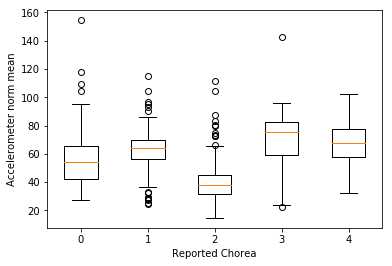

In [45]:
mean_acc_box_plot(home_df, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - reminders patients' reports:

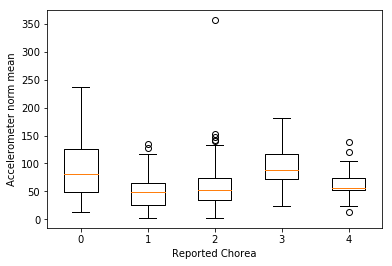

In [46]:
mean_acc_box_plot(reminders_df, 'patient_report_value', 'acc_abs_delta', group_by='reminder_id')

## REVISIT WHEN STEPS RESOLUTION IS AVAILABLE - Inspect the accelerometer data during home assessments vs. during home pre-reminder 5-minutes segments:

In [49]:
clinic_step_agg = clinic_steps_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

,step_name,acc_abs_delta
3,Sit relaxed,52.509823
2,Sit extended,60.307449
4,Stand,71.647589
0,Drink,83.985035
5,TUaG,102.057856
6,Walk,140.883266
1,Rotate hands,202.597351


In [50]:
home_step_agg = home_steps_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
home_step_agg.sort_values(by='acc_abs_delta', inplace=True)
home_step_agg

,step_name,acc_abs_delta
0,Sit relaxed,40.661383
1,Stand,54.612115


In [41]:
clinic_steps_df.step_name.unique()

array(['Sit relaxed', 'TUaG', 'Sit extended', 'Rotate hands', 'Stand',
       'Drink', 'Walk'], dtype=object)

In [51]:
static_steps = ['Sit extended', 'Sit relaxed', 'Stand']

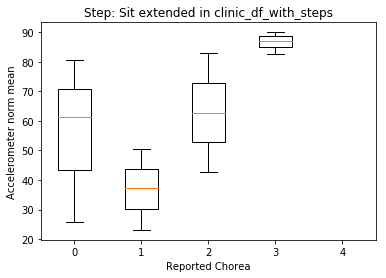

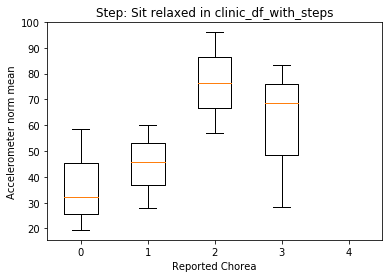

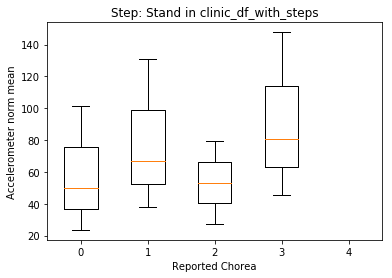

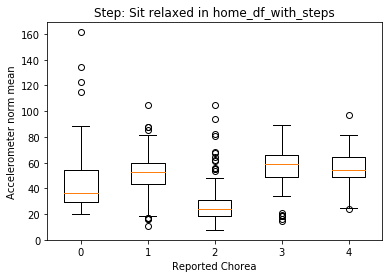

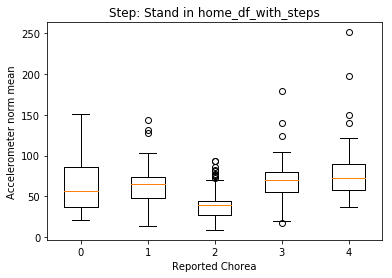

In [52]:
discrete_report_values = c.report_values
for df in [clinic_steps_df, home_steps_df]:
    for step in static_steps:
        if step in df['step_name'].unique().tolist():
            step_df = df[df['step_name']==step]
            agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'patient_report_value']]\
                  .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
            boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['patient_report_value'] == x]) for x in discrete_report_values]
            plt.boxplot(boxes_vals)
            plt.xticks(range(min_val+1, max_val+2), range(5))
#             plt.ylim((920, 1100))
            plt.xlabel('Reported Chorea')
            plt.ylabel('Accelerometer norm mean')
            plt.title('Step: %s in %s' % (step, df.name))
            plt.show()
            plt.close()

In [103]:
home_energy = home_df.total_energy
reminders_energy = reminders_df.total_energy

In [72]:
print('Mean of energy during home assessments:', round(np.mean(home_energy)/1000, 5), '[g]')
print('Mean of energy during home pre-reminder 5-minutes segments:', round(np.mean(reminders_energy)/1000, 5), '[g]')
t, p = ttest_ind(home_energy, reminders_energy)
print('t-test: %.3f \np-value of: %.3f' % (t, p))

Mean of energy during home assessments: 1.0267 [g]
Mean of energy during home pre-reminder 5-minutes segments: 1.01933 [g]
t-test: 124.582 
p-value of: 0.000


In [101]:
home_energy_per_user = home_df[['user_id', 'total_energy']].groupby('user_id').agg('mean')
home_energy_per_user.columns = ['home_total_energy']
home_energy_per_user.sort_index(inplace=True)
# print('Per-user total energy during home assessments:', '\n\n' ,home_energy_per_user)
reminders_energy_per_user = reminders_df[['user_id', 'total_energy']].groupby('user_id').agg('mean')
reminders_energy_per_user.columns = ['reminders_total_energy']
reminders_energy_per_user.sort_index(inplace=True)
# print('\n\n' 'Per-user total energy during home pre-reminder 5-minutes segments:', '\n\n', reminders_energy_per_user)

In [102]:
both_energies = pd.concat([home_energy_per_user, reminders_energy_per_user], axis=1)
both_energies['assessments minus pre-reminders'] = both_energies.home_total_energy - both_energies.reminders_total_energy
both_energies

,home_total_energy,reminders_total_energy,assessments minus pre-reminders
user_id,,,
8,990.804685,1024.630529,-33.825844
25,1035.290394,NaN,NaN
45,1042.890194,1038.855375,4.034819
51,1040.430134,1042.615525,-2.185391
57,1012.427766,1014.745417,-2.317651
63,981.711292,1008.861375,-27.150083
74,1018.078452,1016.087288,1.991165
82,989.172767,1019.048141,-29.875374
94,1042.084485,1042.323606,-0.239121
